In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
_ = torch.manual_seed(42)

from sbi.utils import BoxUniform
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

from model import SocialGPModelSBI
from rewards import sample_children_with_corr

In [3]:
seed = 0
rng: np.random.Generator = np.random.default_rng(seed)

In [4]:
rho_child_child = 0.6
_, child_maps = sample_children_with_corr(
            rng=rng,
            n_children=4,
            length_scale=2.0,
            rho_parent_child=rho_child_child,
            rho_child_child=rho_child_child,
            tol=0.1,
            max_tries=1000
        )

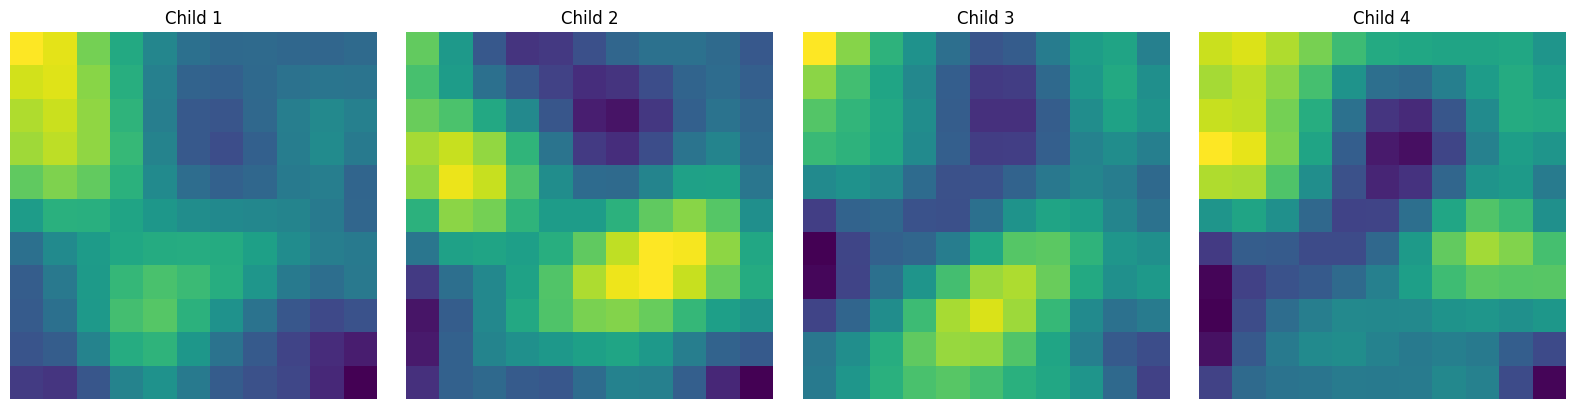

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # 1 row, 4 columns

for i, (c, ax) in enumerate(zip(child_maps, axes)):
    ax.imshow(c)
    ax.set_title(f"Child {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

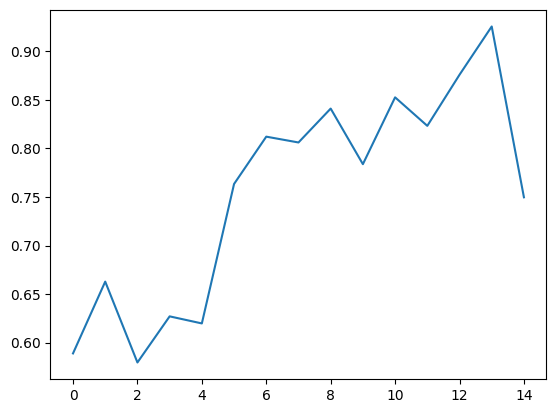

In [6]:
m = SocialGPModelSBI(child_maps, rng=rng, length_scale=1.11, observation_noise_private=0.0001, observation_noise_social=3, tau=0.03, beta=0.33)

for _ in range(15):
    m.step()
plt.plot(m.datacollector.get_model_vars_dataframe()['avg_reward']);

## Prior

In [7]:
# length_scale, observation_noise_social, beta, tau
lower_bound = torch.as_tensor([0.05, 0.0001, 0.05, 0.005])
upper_bound = torch.as_tensor([4.0, 20, 2.0, 0.1])
prior = BoxUniform(low=lower_bound, high=upper_bound)
prior

BoxUniform(Uniform(low: torch.Size([4]), high: torch.Size([4])), 1)

In [10]:
theta = prior.sample((20_000,))
theta

tensor([[3.5243e+00, 1.3946e+01, 5.0839e-01, 5.5283e-02],
        [2.9721e+00, 1.0256e+01, 1.6097e+00, 9.9530e-02],
        [1.6887e+00, 1.7235e+01, 1.9466e-01, 6.9313e-02],
        ...,
        [1.9287e+00, 6.8897e+00, 6.9745e-01, 5.0312e-03],
        [2.2202e+00, 1.6622e+01, 1.9937e+00, 2.4759e-02],
        [1.1750e+00, 5.8791e+00, 1.6984e+00, 7.9071e-02]])

## Simulate function

In [9]:
def simulate(parameters):
    length_scale = parameters[0]
    observation_noise_social = parameters[1]
    beta = parameters[2]
    tau = parameters[3]

    rho_child_child = 0.6
    _, child_maps = sample_children_with_corr(
                rng=rng,
                n_children=4,
                length_scale=2.0,
                rho_parent_child=rho_child_child,
                rho_child_child=rho_child_child,
                tol=0.1,
                max_tries=1000
            )

    _model = SocialGPModelSBI(
        child_maps, 
        rng=rng, 
        observation_noise_private=0.0001,
        length_scale=parameters[0], 
        observation_noise_social=parameters[1],
        beta=parameters[2],
        tau=parameters[3]
    )

    for _ in range(15):
        _model.step()
    results = _model.datacollector.get_model_vars_dataframe()
    
    return results.loc[:, "avg_reward"].to_numpy()


In [11]:
def parallel_simulate(theta):
    # Our simulator uses numpy, but prior samples are in PyTorch.
    theta_np = theta.numpy()

    num_workers = 8
    simulation_outputs = Parallel(n_jobs=num_workers)(
        delayed(simulate)(batch)
        for batch in theta_np
    )
    return np.asarray(simulation_outputs)


In [12]:
%%time
simulation_outputs = parallel_simulate(theta)

CPU times: user 11.3 s, sys: 2.38 s, total: 13.6 s
Wall time: 9min 18s


In [13]:
df = pd.DataFrame(simulation_outputs)

<Axes: xlabel='variable', ylabel='value'>

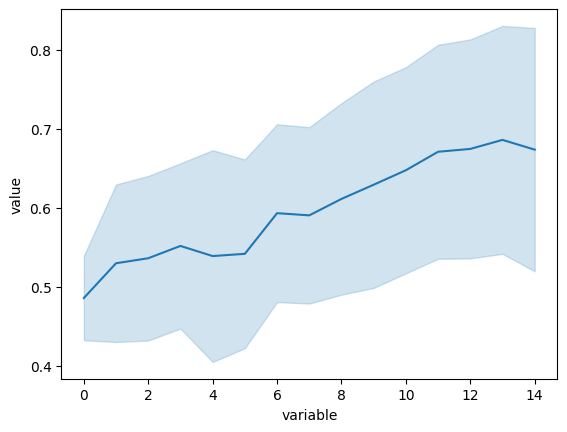

In [14]:
sns.lineplot(df.melt(), x="variable", y="value", errorbar="sd")

In [15]:
x = torch.as_tensor(simulation_outputs, dtype=torch.float32)

## Neural Posterior Estimation (NPE)

In [16]:
from sbi.inference import NPE

inference = NPE(density_estimator="nsf")

In [17]:
%%time
posterior_net = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 85 epochs.CPU times: user 6min 55s, sys: 27.2 s, total: 7min 22s
Wall time: 1min 59s


For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/valery/SIOI/Spatial-MAB-ABM/abm/sbi-logs/NPE_C/2025-06-24T18_28_35.265654' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


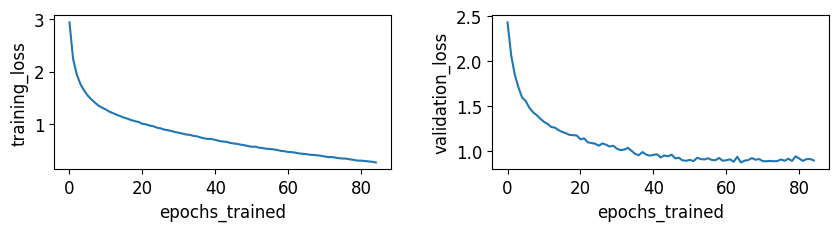

In [18]:
from sbi.analysis import plot_summary
_ = plot_summary(
    inference,
    tags=["training_loss", "validation_loss"],
    figsize=(10, 2),
)

In [20]:
posterior = inference.build_posterior()
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


## Inferring the Posterior

In [21]:
subj_data_all = pd.read_csv("data/e1_data.csv")

In [22]:
subj_data_all.head()

,Unnamed: 0,compfail,group,agent,trial,round,scaling,choice,isRandom,reward,...,expl_eff,uncovered_ind,max_rew,uncoverage,uncoverage_grp,max_rew_grp,prev_rew_grp,max_rew_prop,prev_rew_prop,uncoverage_prop
0,1,2,0,1,0,0,64,97,1,0.2540,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2,2,0,1,1,0,64,6,1,0.8249,...,0.5709,NaN,0.2540,1.0,4.0,NaN,0.348100,NaN,0.729675,0.250000
2,3,2,0,1,2,0,64,23,0,0.6730,...,-0.1519,NaN,0.8249,2.0,7.0,0.34810,0.542025,2.369721,1.521886,0.285714
3,4,2,0,1,3,0,64,57,1,0.0500,...,-0.6230,NaN,0.8249,3.0,11.0,0.59695,0.710975,1.381858,0.946587,0.272727
4,5,2,0,1,4,0,64,16,0,0.9155,...,0.8655,NaN,0.8249,4.0,13.0,0.81005,0.432250,1.018332,0.000000,0.307692


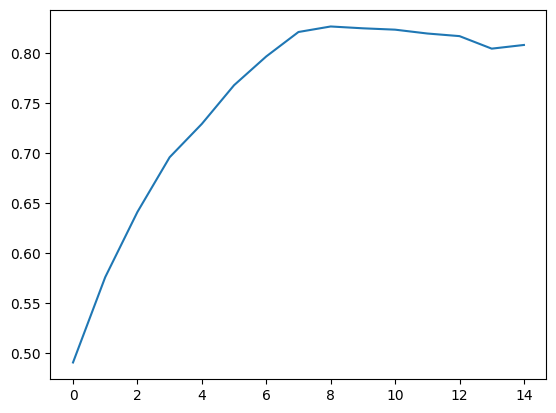

In [23]:
x_obs = subj_data_all.groupby(["trial"])["reward"].mean()
plt.plot(x_obs);

In [24]:
samples = posterior.sample((500_000,), x=x_obs)

Drawing 500000 posterior samples:   0%|          | 0/500000 [00:00<?, ?it/s]

/Users/valery/Library/Caches/pypoetry/virtualenvs/spatial-mab-abm-icOMRY7y-py3.12/lib/python3.12/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2196.)
  outputs, _ = torch.triangular_solve(


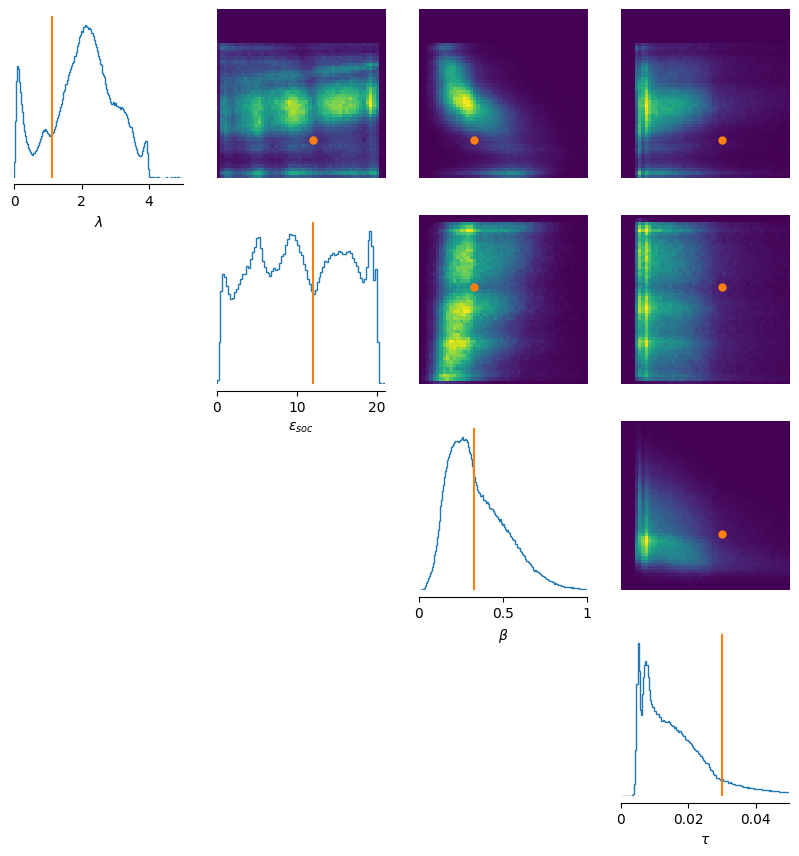

In [64]:
from sbi.analysis import pairplot
_ = pairplot(
    samples,
    limits=[[0, 5], [0, 21], [0, 1], [0, 0.05]],
    # ticks=[[0, 5], [-1, 20], [0, 1], [0, 0.05]],
    # ticks=[[0.05, 0.2], [0.01, 0.05], [0.005, 0.05], [0.005, 0.2]],
    points=[[1.11, 12, 0.33, 0.03]],
    figsize=(10, 10),
    labels=["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"]
)

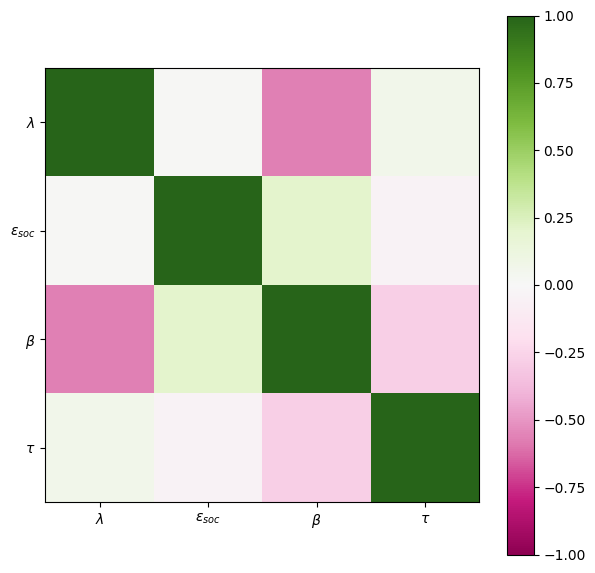

In [66]:
corr_matrix_marginal = np.corrcoef(samples.T)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap="PiYG")
plt.xticks(range(4), ["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"])
plt.yticks(range(4), ["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"])
_ = fig.colorbar(im)

## Analysing variability and compensation mechanisms

In [26]:
from sbi.analysis import (
    conditional_corrcoeff,
    conditional_pairplot,
    conditional_potential,
    pairplot,
)
from sbi.inference import (
    MCMCPosterior,
    posterior_estimator_based_potential,
)


In [48]:
posterior.set_default_x(x_obs)

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

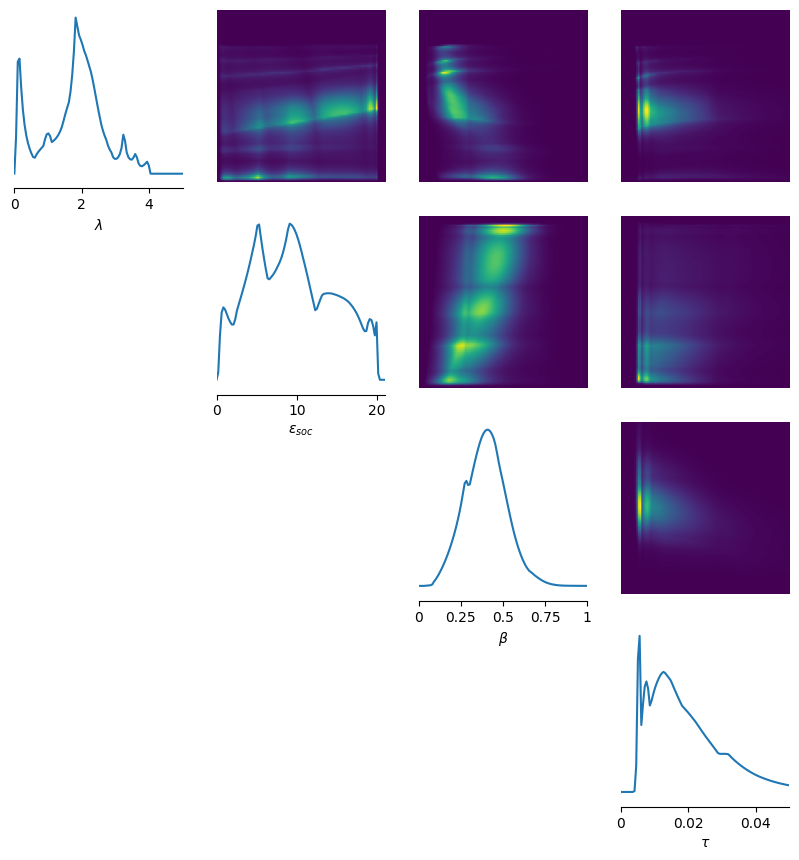

In [65]:
_ = conditional_pairplot(
    density=posterior,
    condition=torch.as_tensor([[1.11, 12, 0.33, 0.03]]),
    resolution=100,
    limits=torch.tensor([[0, 5], [0, 21], [0, 1], [0, 0.05]]),
    figsize=(10, 10),
    labels=["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"]
)


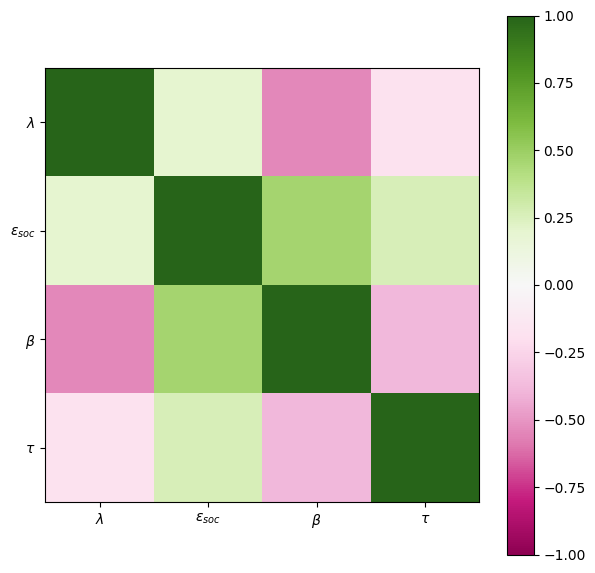

In [67]:
cond_coeff_mat = conditional_corrcoeff(
    density=posterior,
    condition=torch.as_tensor([[1.11, 12, 0.33, 0.03]]),
    limits=torch.tensor([[0, 5], [0, 21], [0, 1], [0, 0.05]]),
)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap="PiYG")
plt.xticks(range(4), ["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"])
plt.yticks(range(4), ["$\\lambda$", "$\\epsilon_{soc}$", "$\\beta$", "$\\tau$"])
_ = fig.colorbar(im)

### Sampling conditional distributions

In [28]:
potential_fn, theta_transform = posterior_estimator_based_potential(
    posterior_net, prior=prior, x_o=x_obs
)

In [29]:
conditioned_potential_fn, restricted_tf, restricted_prior = conditional_potential(
    potential_fn=potential_fn,
    theta_transform=theta_transform,
    prior=prior,
    condition=torch.as_tensor(
        [0.0, 0.0, 0.33, 0.03]
    ),  # the first n values are arbitrary and are ignored internally
    dims_to_sample=[0, 1],
)

In [37]:
mcmc_posterior = MCMCPosterior(
    potential_fn=conditioned_potential_fn,
    theta_transform=restricted_tf,
    proposal=restricted_prior,
    method="slice_np_vectorized",
    num_chains=20,
).set_default_x(x_obs)
cond_samples = mcmc_posterior.sample((50_000,))

Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/55000 [00:00<?, ?it/s]

In [55]:
simulation_outputs.shape

(10000, 300)

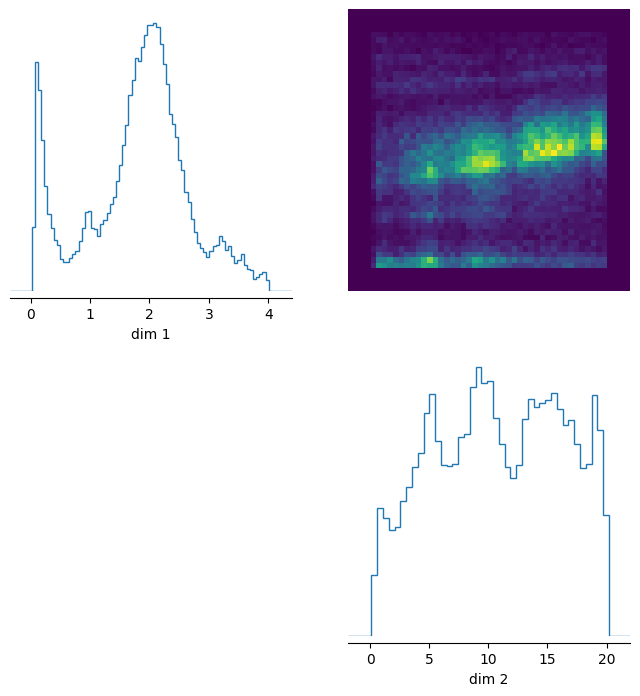

In [38]:
pairplot(cond_samples, figsize=(8, 8), diag_kwargs=dict(bins="auto"));

In [39]:
conditioned_potential_fn, restricted_tf, restricted_prior = conditional_potential(
    potential_fn=potential_fn,
    theta_transform=theta_transform,
    prior=prior,
    condition=torch.as_tensor(
        [1.11, 0.0, 0.33, 0.03]
    ),  # the first n values are arbitrary and are ignored internally
    dims_to_sample=[1],
)

In [40]:
mcmc_posterior = MCMCPosterior(
    potential_fn=conditioned_potential_fn,
    theta_transform=restricted_tf,
    proposal=restricted_prior,
    method="slice_np_vectorized",
    num_chains=20,
).set_default_x(x_obs)
cond_samples = mcmc_posterior.sample((50_000,))

Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/55000 [00:00<?, ?it/s]

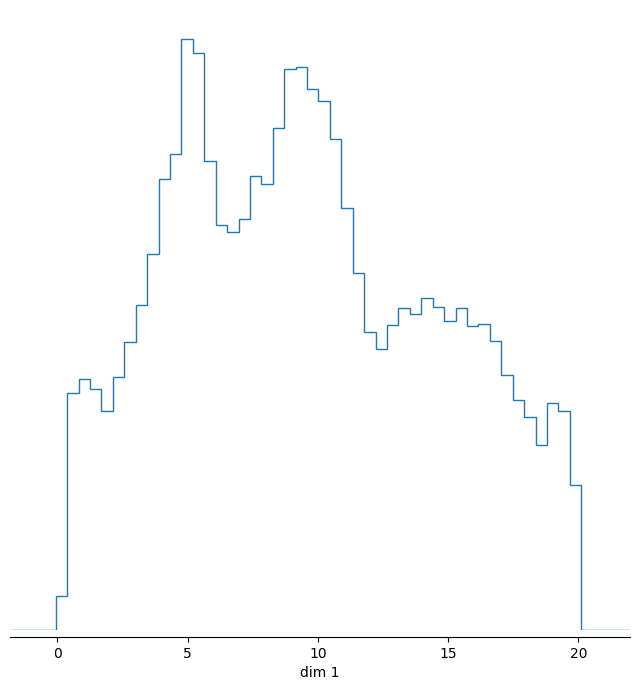

In [41]:
pairplot(cond_samples, figsize=(8, 8), diag_kwargs=dict(bins="auto"));